In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Clone github repo
!git clone https://github.com/wwentink/pneumonia-detection.git

fatal: destination path 'pneumonia-detection' already exists and is not an empty directory.


In [8]:
# Paths to data
train_dir = "/content/pneumonia-detection/data/chest_xray/train"
val_dir = "/content/pneumonia-detection/data/chest_xray/val"
test_dir = "/content/pneumonia-detection/data/chest_xray/test"

# Overall parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 40

In [9]:
# Create training, validation, and testing datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print(f"Classes: {class_names}")

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


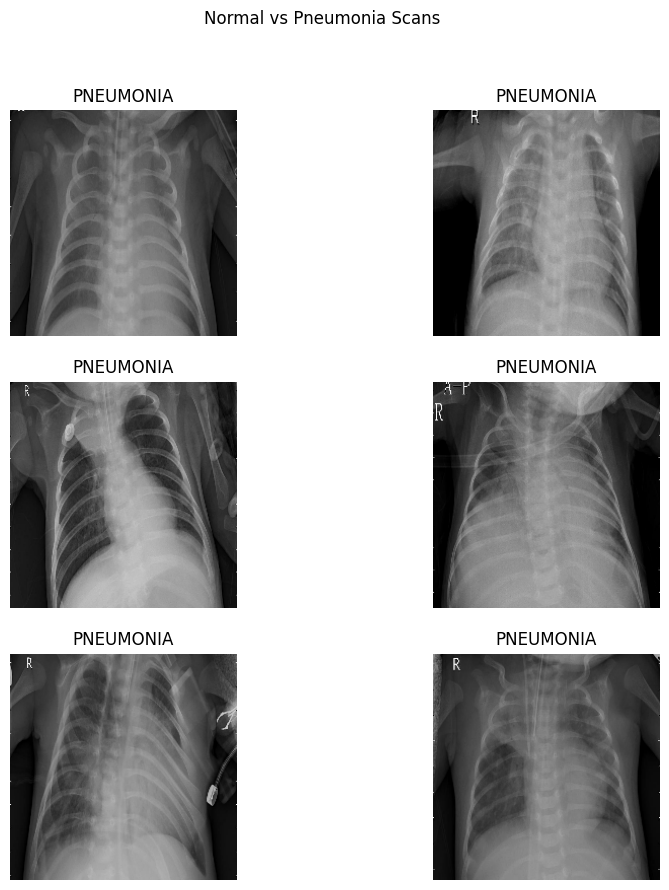

In [10]:
# Visualization
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Examples of Chest Scans")
plt.show()

In [11]:
# Augmentation for training data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

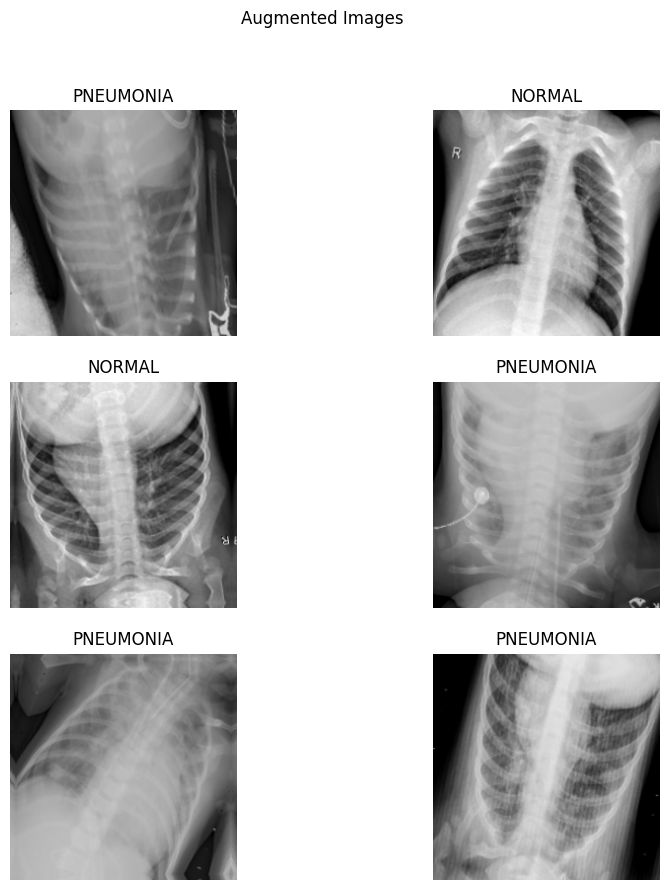

In [12]:
# Ensure images are float and scaled to [0, 1] before augmentation
rescale = tf.keras.layers.Rescaling(1./255)


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    images = rescale(images) # Rescale images
    augmented_images = data_augmentation(images)
    for i in range(6):
        ax = plt.subplot(3, 2, i + 1)
        plt.imshow(np.clip(augmented_images[i].numpy(), 0.0, 1.0))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Augmented Images")
plt.show()

In [13]:
# Autotune to speed up training

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,))

base_model.trainable = False

inputs = layers.Input(shape = IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [15]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [16]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, verbose=1),
    ModelCheckpoint("bestmodel.keras", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 242ms/step - accuracy: 0.7805 - loss: 0.4545 - val_accuracy: 0.6250 - val_loss: 0.5637 - learning_rate: 0.0010
Epoch 2/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 222ms/step - accuracy: 0.9006 - loss: 0.2415 - val_accuracy: 0.8125 - val_loss: 0.4082 - learning_rate: 0.0010
Epoch 3/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 203ms/step - accuracy: 0.9132 - loss: 0.2114 - val_accuracy: 0.8750 - val_loss: 0.3116 - learning_rate: 0.0010
Epoch 4/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 193ms/step - accuracy: 0.9164 - loss: 0.2029 - val_accuracy: 0.8750 - val_loss: 0.3494 - learning_rate: 0.0010
Epoch 5/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 208ms/step - accuracy: 0.9236 - loss: 0.1893 - val_accuracy: 0.8125 - val_loss: 0.3998 - learning_rate: 0.0010
Epoch 6/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - accuracy: 0.9343 - loss: 0.1701 - val_accuracy: 0.8125 - val_loss: 0.3471 - learning_rate: 5.0000e-04
Epoch 7/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - accuracy:

In [20]:
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 221ms/step - accuracy: 0.9489 - loss: 0.1374 - val_accuracy: 1.0000 - val_loss: 0.1406 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 205ms/step - accuracy: 0.9526 - loss: 0.1238 - val_accuracy: 1.0000 - val_loss: 0.1377 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - accuracy: 0.9449 - loss: 0.1340 - val_accuracy: 1.0000 - val_loss: 0.1370 - learning_rate: 1.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.9540 - loss: 0.1201 - val_accuracy: 0.9375 - val_loss: 0.1374 - learning_rate: 1.0000e-05
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 204ms/step - accuracy: 0.9542 - loss: 0.1178 - val_accuracy: 1.0000 - val_loss: 0.1324 - learning_rate: 1.0000e-05
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - accuracy: 0.9527 - loss: 0.1233 - val_accuracy: 0.9375 - val_loss: 0.1360 - learning_rate: 1.0000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 19

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.7457 - loss: 0.6104
Test Accuracy: 0.8526
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step
              precision    recall  f1-score   support

      NORMAL       0.95      0.64      0.77       234
   PNEUMONIA       0.82      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.87      0.85      0.84       624



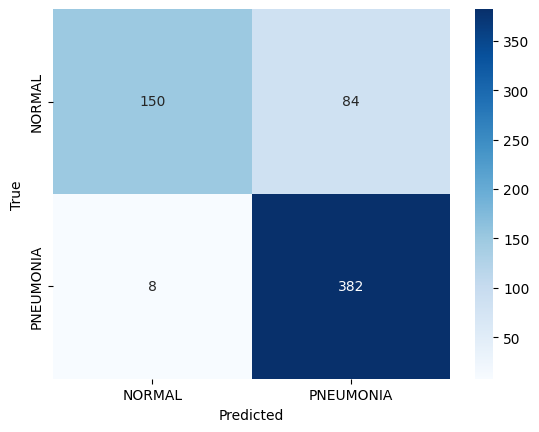

In [21]:
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.4f}")

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NORMAL", "PNEUMONIA"],
            yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()